# Denver 2016 B-cycle Trip Data Exploration

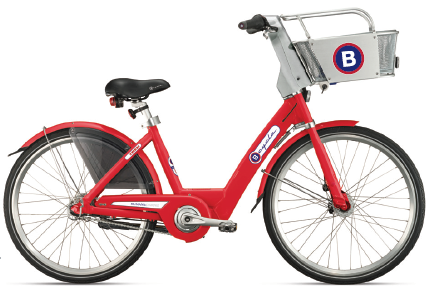

In [1]:
from IPython.display import Image
image = Image('data/DenverBike.png')
image
# Source: http://denver.bcycle.com/docs/librariesprovider34/default-document-library/dbs_annualreport_2016_05.pdf

## 1. Introduction

[Denver B-cycle](https://denver.bcycle.com/) is a non-profit public bike sharing organization operating an automated bike sharing system called Denver B-cycle. Its mission is to "serve as a catalyst to fundamentally transform public thinking and behavior by operating a bike sharing system in Denver to enhance mobility while promoting all aspects of sustainability: quality of life, equity, the environment, economic development, and public health"  its purpose, its organization and discuss its relevance to this exploration.


Denver B-cycle posts its trips data set on its website as soon as its annual report is released. Trips data is available going back to 2011. The 2016 annual report and its associated dataset for this report were obtained from (https://www.denverbcycle.com/company). The original plan was to use the 2015 dataset to continue the effort by Tyler Byler who published a report [Exploring 2014 Denver B-cycle Ridership](https://github.com/tybyers). However, the 2016 data became available at the end of February 2017, so gears had to be rapidly shifted to use this data instead. To this end, the reporting style will follow Tyler's study to provide seamless continuity and good reference on trends and analyses.

## 2. The Datasets

The dataset is in an Excel .xlsx format and is a 27.2MB file. The Kiosk Information file is only 15.6KB in size. Because GitHub does not allow any file larger than 25MB, it was necessary to load it from the website at (http://denver.bcycle.com/docs/librariesprovider34/default-document-library/2016denverbcycletripdata_public.xlsx?sfvrsn=2) and compress it so that it could be uploaded to the GitHub repository.

In [2]:
# import necessary libraries and modules
import pandas as pd
import numpy as np
from numpy import datetime64
import csv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# set display options for pandas output
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# take from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))
%matplotlib inline

In [3]:
# read converted csv compressed file from Excel xlsx. Bike_Number has mixed data types,
# so it needs to be declared as an object
dF = pd.read_csv("data/2016_Denver_Bike_Trip_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
# main dataframe has 419611 rows of data
dF.shape

(419611, 11)

### Trips dataframe data structure

Trips dataframe has 11 columns, two int64 and 9 object data types. The column names were updated in 
Denver_2016_Excel_to_CSV_File_Conversion.ipynb
The original columns in the Excel file were ["User's Program", "User ID", "Membership Type", "Bike", "Checkout Date",
"Checkout Time", "Checkout Kiosk", "Return Date", "Return Time", "Return Kiosk", "Duration (Minutes)"]

In [5]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419611 entries, 0 to 419610
Data columns (total 11 columns):
User_Program       419611 non-null object
User_ID            419611 non-null int64
Membership_Type    419611 non-null object
Bike_Number        419611 non-null object
Checkout_Date      419611 non-null object
Checkout_Time      419611 non-null object
Checkout_Kiosk     419611 non-null object
Return_Date        419611 non-null object
Return_Time        419611 non-null object
Return_Kiosk       419611 non-null object
Trip_Duration      419611 non-null int64
dtypes: int64(2), object(9)
memory usage: 35.2+ MB


In [6]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
0,Denver B-cycle,1062815,Annual Plus (Denver B-cycle),544,2016-12-31,05:08:00,15th & Curtis,2016-12-31,05:20:00,Denver Public Library,12
1,Denver B-cycle,1445221,24-hour Kiosk Only (Denver B-cycle),505,2016-12-31,07:22:00,16th & Sherman,2016-12-31,08:03:00,16th & Wynkoop,41
2,Denver B-cycle,1296335,Monthly (Denver B-cycle),210,2016-12-31,07:23:00,22nd & Market,2016-12-31,07:26:00,18th & Arapahoe,3


### Convert Checkout_Date and Return_Date columns to DateTime64 datatype

In [7]:
dF['Checkout_Date'] = dF[['Checkout_Date']].astype('datetime64[ns]')
dF['Return_Date'] = dF[['Return_Date']].astype('datetime64[ns]')

In [8]:
# Sort checkout dates in ascending order
dF.sort_values(['Checkout_Date'], inplace=True)

In [9]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
419610,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23:21:00,Market Street Station,2016-01-01,23:23:00,19th & Market,2
419442,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13:19:00,REI,2016-01-01,13:46:00,Broadway & Walnut,27
419441,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13:19:00,10th & Osage,2016-01-01,13:46:00,10th & Osage,27


## 3. Data Wrangling

### Filtering the main dataframe to obtain actual miles ridden

Denver B-cycle prides itself on the number of trips and miles ridden by its members or customers. In order to be as accurate
as possibe, the dataset needs to be filtered accordingly. To start off, rows with a trip duration of one minute account for
**10,115** of the 419,611 rows **(2.4%)** in the dataset. Incidentally, these rows also show the Checkout Kiosk and the Return Kiosk to be the same. It is possible that riders were not pleased with their bike selection and returned them in a few minutes after renting them.

In [10]:
# Check to see number of trips made with 25 minutes or less
dX = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] < 26)]

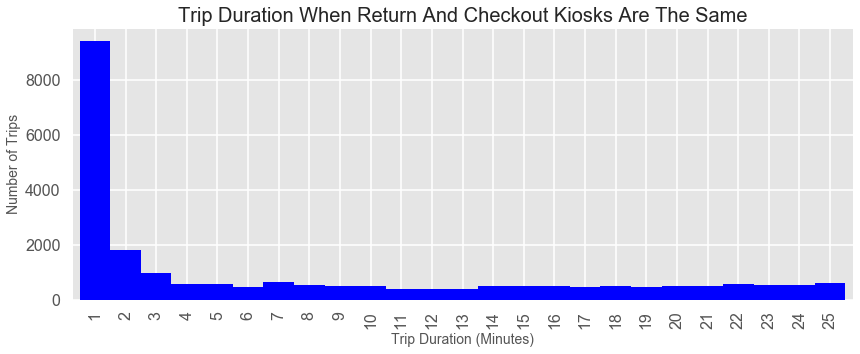

In [11]:
# plot the results
ax = dX.groupby('Trip_Duration').size().plot(kind='bar', figsize=(14,5), color='blue', width=1.0, xlim=(0,15))
plt.title('Trip Duration When Return And Checkout Kiosks Are The Same', fontsize = 20)
plt.xlabel('Trip Duration (Minutes)', fontsize = 14)
plt.ylabel('Number of Trips', fontsize = 14)
plt.show()

In [12]:
# remove rows that have a trip duration of 1 minute
dF.drop(dF[dF['Trip_Duration'] == 1].index, inplace = True)

### Estimated Trips = 409,496

In [13]:
# main dataframe has 409496 rows to work with, a reduction of 10,115 data rows
dF.shape

(409496, 11)

### Load Kiosk public data, modify column names

The Kiosk Excel file has names, addresses and geopgraphical coordinates of the 89 Checkout and Return Kiosks. This important information was not available prior to 2016 and had to be created manually. This file needs to be prepared for use with additional code to retrieve distances between Kiosks using the Google Distance Matrix API obtained via its site: (https://developers.google.com/maps/documentation/javascript/examples/distance-matrix). This service requires the user to obtain a key that is used to retrieve up to a maximum of 2500 calls per day.

In [14]:
# read in Kiosk information from the Denver Bike Share public data site
dC= pd.read_excel('https://denver.bcycle.com/docs/librariesprovider34/default-document-library/october2016_kioskinfo.xlsx')

In [15]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
  Kiosk Name    89 non-null object
Address         89 non-null object
Longitude       89 non-null float64
Latitude        89 non-null float64
Total Docks     89 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.6+ KB


In [16]:
dC.shape

(89, 5)

In [17]:
# use descriptive column names
new_colnames = ['Checkout_Kiosk', 'Checkout_Kiosk_Address', 'Checkout_Kiosk_Longitude', 
                'Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Total_Docks']
dC.columns = new_colnames

In [18]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
Checkout_Kiosk                89 non-null object
Checkout_Kiosk_Address        89 non-null object
Checkout_Kiosk_Longitude      89 non-null float64
Checkout_Kiosk_Latitude       89 non-null float64
Checkout_Kiosk_Total_Docks    89 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.6+ KB


In [19]:
# don't need address and docks for retrieving distances from Google Distance API
dC.drop(['Checkout_Kiosk_Address', 'Checkout_Kiosk_Total_Docks'], axis = 1, inplace=True)

In [20]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
Checkout_Kiosk              89 non-null object
Checkout_Kiosk_Longitude    89 non-null float64
Checkout_Kiosk_Latitude     89 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


In [21]:
# make a copy for Return Kiosks
dR = dC.copy(deep=True)

In [22]:
dR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
Checkout_Kiosk              89 non-null object
Checkout_Kiosk_Longitude    89 non-null float64
Checkout_Kiosk_Latitude     89 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


In [23]:
# use descriptive column names
new_colnames = ['Return_Kiosk', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude']
dR.columns = new_colnames

In [24]:
# add Return Kiosks details to Checkout Kiosks details
dCR = pd.concat([dC, dR], axis = 1)

### Save Kiosk data for use with Google Distance Matrix API

File is ready for use with additional python/pandas code (Denver_Bike_Share_Distance_Duration_Submit.py) to retrieve distances between Kiosks using the Google Distance Matrix API. The retrieved distances are saved in (Denver_Bike_Kiosks_Distances_Durations.csv).

In [25]:
# save dataframe to csv file for use in getting distances from Googe Distance API
dCR.to_csv('data/Denver_Bike_Kiosks_Details.csv', index = False)

### Retrieve Kiosk distances and add Kiosks that have the same starting and ending trip information

File is ready for merging with the Trips dataframe in order to calculate the total miles ridden. But prior to this, 89 more data rows where the Checkout Kiosk and the Return Kiosk are the same have to added to the retrieved file that has distances retrieved from Google. These 89 rows will have the Trip_Distance column reporting zeros but there could be bikes rented from the Checkout Kiosk and returned to it which is considered valid data.

In [26]:
# read in distance information retrieved from Google Distance API
dK = pd.read_csv('data/Denver_Bike_Kiosks_Distances_Durations.csv')

In [27]:
# Drop columns that are not relevant for merging with the Trips dataframe
dK.drop(['Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Longitude', 'Return_Kiosk_Latitude', 'Return_Kiosk_Longitude',
         'Distance_Checkout_Return', 'Duration_Checkout_Return', 'Distance_Return_Checkout',
         'Duration_Return_Checkout', 'Average_Duration'], axis = 1, inplace = True)

In [28]:
dK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7832 entries, 0 to 7831
Data columns (total 3 columns):
Checkout_Kiosk      7832 non-null object
Return_Kiosk        7832 non-null object
Average_Distance    7832 non-null float64
dtypes: float64(1), object(2)
memory usage: 183.6+ KB


In [29]:
# read csv file for use in 
dCR = pd.read_csv('data/Denver_Bike_Kiosks_Details.csv')

In [30]:
dCR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 6 columns):
Checkout_Kiosk              89 non-null object
Checkout_Kiosk_Longitude    89 non-null float64
Checkout_Kiosk_Latitude     89 non-null float64
Return_Kiosk                89 non-null object
Return_Kiosk_Longitude      89 non-null float64
Return_Kiosk_Latitude       89 non-null float64
dtypes: float64(4), object(2)
memory usage: 4.2+ KB


In [31]:
dD = dCR.where(dCR['Checkout_Kiosk'] == dCR['Return_Kiosk'])

In [32]:
dD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 6 columns):
Checkout_Kiosk              89 non-null object
Checkout_Kiosk_Longitude    89 non-null float64
Checkout_Kiosk_Latitude     89 non-null float64
Return_Kiosk                89 non-null object
Return_Kiosk_Longitude      89 non-null float64
Return_Kiosk_Latitude       89 non-null float64
dtypes: float64(4), object(2)
memory usage: 4.2+ KB


In [33]:
dD.head(3)

,Checkout_Kiosk,Checkout_Kiosk_Longitude,Checkout_Kiosk_Latitude,Return_Kiosk,Return_Kiosk_Longitude,Return_Kiosk_Latitude
0,10th & Osage,-105.005,39.732,10th & Osage,-105.005,39.732
1,11th & Broadway,-104.988,39.734,11th & Broadway,-104.988,39.734
2,11th & Delaware,-104.993,39.734,11th & Delaware,-104.993,39.734


In [34]:
# Drop columns that are not relevant
dD.drop(['Checkout_Kiosk_Longitude', 'Checkout_Kiosk_Latitude', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude'],
        axis = 1, inplace = True)

In [35]:
# add Average_Distance column and fill with zeros
dD['Average_Distance'] = 0

In [36]:
dD.head(3)

,Checkout_Kiosk,Return_Kiosk,Average_Distance
0,10th & Osage,10th & Osage,0
1,11th & Broadway,11th & Broadway,0
2,11th & Delaware,11th & Delaware,0


In [37]:
# add these rows to the retrieved distances dataframe
dK = pd.concat([dK, dD], axis = 0)

In [38]:
# A combination of 89 Checkout and Return Kiosks should give a value of 7921
dK.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7921 entries, 0 to 88
Data columns (total 3 columns):
Checkout_Kiosk      7921 non-null object
Return_Kiosk        7921 non-null object
Average_Distance    7921 non-null float64
dtypes: float64(1), object(2)
memory usage: 247.5+ KB


In [39]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409496 entries, 419610 to 0
Data columns (total 11 columns):
User_Program       409496 non-null object
User_ID            409496 non-null int64
Membership_Type    409496 non-null object
Bike_Number        409496 non-null object
Checkout_Date      409496 non-null datetime64[ns]
Checkout_Time      409496 non-null object
Checkout_Kiosk     409496 non-null object
Return_Date        409496 non-null datetime64[ns]
Return_Time        409496 non-null object
Return_Kiosk       409496 non-null object
Trip_Duration      409496 non-null int64
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 37.5+ MB


### Merge with Trips dataframe and remove invalid rows

In [40]:
# merge distance information retrieved from Google Distance API with Trips dataframe
dF = pd.merge(dF, dK, how='left', left_on=['Checkout_Kiosk', 'Return_Kiosk'], right_on=['Checkout_Kiosk', 'Return_Kiosk'])

In [41]:
# Trips dataframe now has 409539 rows, an increase of 43 rows (409539-409496), possibly due to invalid stations
# and the Average_Distance column shows only 402965 rows of valid data
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409539 entries, 0 to 409538
Data columns (total 12 columns):
User_Program        409539 non-null object
User_ID             409539 non-null int64
Membership_Type     409539 non-null object
Bike_Number         409539 non-null object
Checkout_Date       409539 non-null datetime64[ns]
Checkout_Time       409539 non-null object
Checkout_Kiosk      409539 non-null object
Return_Date         409539 non-null datetime64[ns]
Return_Time         409539 non-null object
Return_Kiosk        409539 non-null object
Trip_Duration       409539 non-null int64
Average_Distance    402965 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 40.6+ MB


In [42]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Average_Distance
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23:21:00,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.260
1,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13:19:00,REI,2016-01-01,13:46:00,Broadway & Walnut,27,1.995
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13:19:00,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,0.000


In [43]:
# Check to confirm there are null values in the dataframe
dF.isnull().values.any()

True

In [44]:
# locate the rows with null data 
nan_rows = dF[dF.isnull().T.any().T]

### Rows with invalid Kiosks = 6574

In [45]:
# found 6574 rows!! - mostly from DBS LARIMER WAREHOUSE and 'Dead and Missing Bikes' Kiosks which are not in the Kiosk List!!
nan_rows.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Average_Distance
13,Denver B-cycle,796349,Not Applicable,402,2016-01-01,12:59:00,22nd & Market,2016-01-01,15:19:00,DBS LARIMER WAREHOUSE,140,nan
18,Denver B-cycle,796349,Not Applicable,449,2016-01-01,12:50:00,16th & Boulder,2016-01-01,15:19:00,DBS LARIMER WAREHOUSE,149,nan
19,Denver B-cycle,796349,Not Applicable,363,2016-01-01,12:50:00,16th & Boulder,2016-01-01,15:18:00,DBS LARIMER WAREHOUSE,148,nan


In [46]:
# remove these 6574 rows from the dataframe
dF = dF.drop(dF.index[nan_rows.index])

In [47]:
# Main dataframe now has 402,965 rows to work with
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402965 entries, 0 to 409538
Data columns (total 12 columns):
User_Program        402965 non-null object
User_ID             402965 non-null int64
Membership_Type     402965 non-null object
Bike_Number         402965 non-null object
Checkout_Date       402965 non-null datetime64[ns]
Checkout_Time       402965 non-null object
Checkout_Kiosk      402965 non-null object
Return_Date         402965 non-null datetime64[ns]
Return_Time         402965 non-null object
Return_Kiosk        402965 non-null object
Trip_Duration       402965 non-null int64
Average_Distance    402965 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 40.0+ MB


In [48]:
dF.rename(columns = {'Average_Distance' : 'Trip_Distance'}, inplace = True)

In [49]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23:21:00,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.260
1,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13:19:00,REI,2016-01-01,13:46:00,Broadway & Walnut,27,1.995
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13:19:00,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,0.000


In [50]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402965 entries, 0 to 409538
Data columns (total 12 columns):
User_Program       402965 non-null object
User_ID            402965 non-null int64
Membership_Type    402965 non-null object
Bike_Number        402965 non-null object
Checkout_Date      402965 non-null datetime64[ns]
Checkout_Time      402965 non-null object
Checkout_Kiosk     402965 non-null object
Return_Date        402965 non-null datetime64[ns]
Return_Time        402965 non-null object
Return_Kiosk       402965 non-null object
Trip_Duration      402965 non-null int64
Trip_Distance      402965 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 40.0+ MB


### Estimate Trip Distance for Kiosks that have the same starting and ending trip information

In [51]:
# Valid data that needs to aggregated to total distance
# Checkout Kiosk == Return_Kiosk and Trip_Distance == 0
dD = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Distance"] == 0)]

In [52]:
# valid data rows = 31349
dD.shape

(31349, 12)

In [53]:
dD.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13:19:00,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,0.000
14,Denver B-cycle,1051945,24-hour Kiosk Only (Denver B-cycle),430,2016-01-01,12:59:00,Cherry Creek Mall,2016-01-01,13:27:00,Cherry Creek Mall,28,0.000
16,Denver B-cycle,1051945,24-hour Kiosk Only (Denver B-cycle),414,2016-01-01,12:58:00,Cherry Creek Mall,2016-01-01,13:27:00,Cherry Creek Mall,29,0.000


In [54]:
dD['Trip_Duration'].sum()

1874563

In [55]:
dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum()

9871236

In [56]:
dF['Trip_Distance'].sum()

563745.4099999677

### Estimate average speed for use in Kiosks that have the same and ending trip infomation

In [57]:
avSpeed =  (dF['Trip_Distance'].sum()) /(dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum())

In [58]:
avSpeed # miles/min

0.0571099110587537

In [59]:
dE = dD.copy(deep=True)

In [60]:
# Multiply the trip duration by average speed to get distance
dE['Trip_Distance'] = dE['Trip_Duration'].map(lambda x: x*avSpeed)

In [61]:
# drop columns that are not relevant to the merge with the Trips dataframe
dE.drop(dE.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis=1, inplace=True)

In [62]:
dE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31349 entries, 2 to 409522
Data columns (total 1 columns):
Trip_Distance    31349 non-null float64
dtypes: float64(1)
memory usage: 489.8 KB


In [63]:
# merge the 31453 rows into the 409539 rows of the main dataframe
dF = pd.merge(dF, dE, how = 'left', left_index=True, right_index= True)

In [64]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402965 entries, 0 to 409538
Data columns (total 13 columns):
User_Program       402965 non-null object
User_ID            402965 non-null int64
Membership_Type    402965 non-null object
Bike_Number        402965 non-null object
Checkout_Date      402965 non-null datetime64[ns]
Checkout_Time      402965 non-null object
Checkout_Kiosk     402965 non-null object
Return_Date        402965 non-null datetime64[ns]
Return_Time        402965 non-null object
Return_Kiosk       402965 non-null object
Trip_Duration      402965 non-null int64
Trip_Distance_x    402965 non-null float64
Trip_Distance_y    31349 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2), object(7)
memory usage: 43.0+ MB


In [65]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance_x,Trip_Distance_y
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23:21:00,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.260,nan
1,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13:19:00,REI,2016-01-01,13:46:00,Broadway & Walnut,27,1.995,nan
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13:19:00,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,0.000,1.542


In [66]:
# convert the NaN values to numeric and fill them with zeros
dF[['Trip_Distance_y']] = dF[['Trip_Distance_y']].apply(pd.to_numeric)
dF['Trip_Distance_y'].fillna(0, inplace=True)

In [67]:
# update the distance values in the main dataframe
dF['Trip_Distance'] = dF['Trip_Distance_x'] + dF['Trip_Distance_y']

In [68]:
dF.drop(['Trip_Distance_x'], axis = 1, inplace=True)

In [69]:
dF.drop(['Trip_Distance_y'], axis = 1, inplace=True)

In [70]:
totalDistance = dF['Trip_Distance'].sum()

### Distance Traveled = 670,802 miles

Denver Bike Sharing 2016 Annual Report records estimated miles ridden = **755,409**. This report shows **670,802** miles ridden, a delta of **85,607** or **11%**.

In [71]:
totalDistance

670801.5362039082

### Most Popular Checkout Kiosks

In [72]:
# Most popular Checkout Kiosks
mostPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [73]:
mostPopular.head(10)

Checkout_Kiosk
16th & Wynkoop         11174
16th & Broadway        11116
1350 Larimer           10837
18th & California       9865
1550 Glenarm            9441
18th & Arapahoe         8531
20th & Chestnut         8240
13th & Speer            8228
REI                     8218
16th & Little Raven     8198
dtype: int64

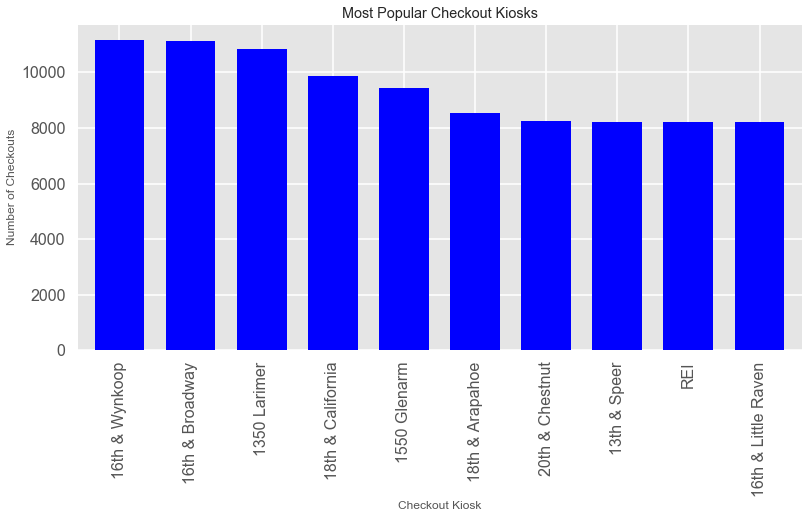

In [74]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Checkout Kiosks")
plt.xlabel('Checkout Kiosk')
plt.ylabel('Number of Checkouts')
plt.show()

### Map of Checkout Kiosk Popularity

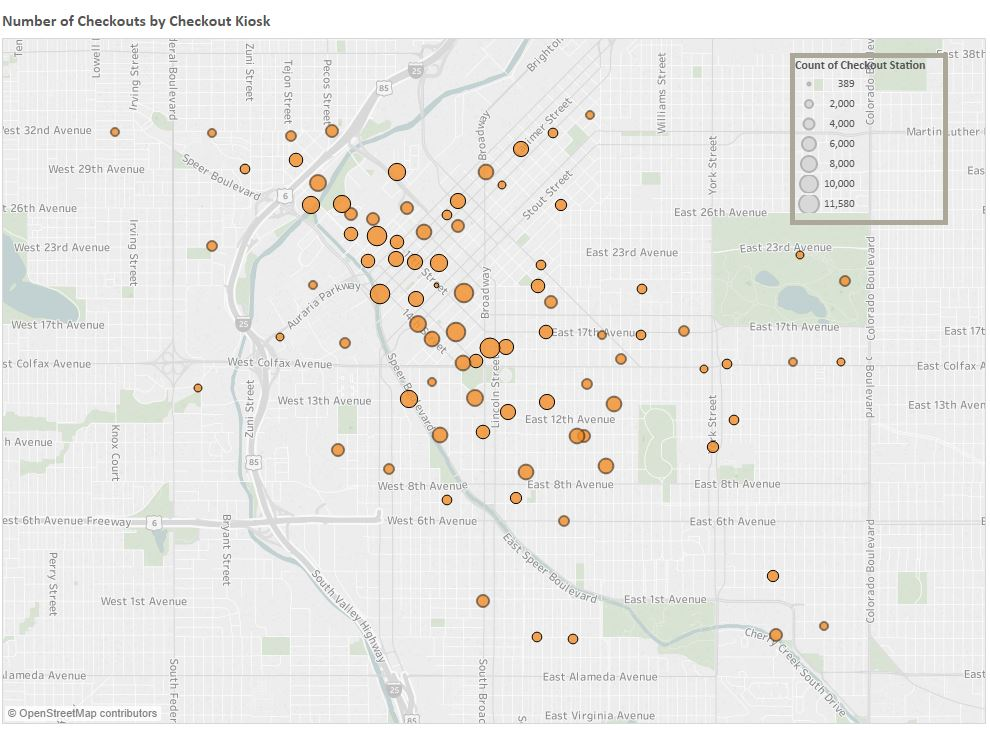

In [75]:
from IPython.display import Image
image = Image('data/Checkouts_By_Checkout_Kiosk.jpg')
image

### Most Popular Return Kiosks

In [76]:
# Most popular Return Kiosks
mostPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [77]:
mostPopular.head(10)

Return_Kiosk
16th & Wynkoop         11289
1350 Larimer           10920
16th & Broadway        10870
18th & California       9863
1550 Glenarm            9501
18th & Arapahoe         8549
20th & Chestnut         8356
REI                     8284
13th & Speer            8272
16th & Little Raven     8267
dtype: int64

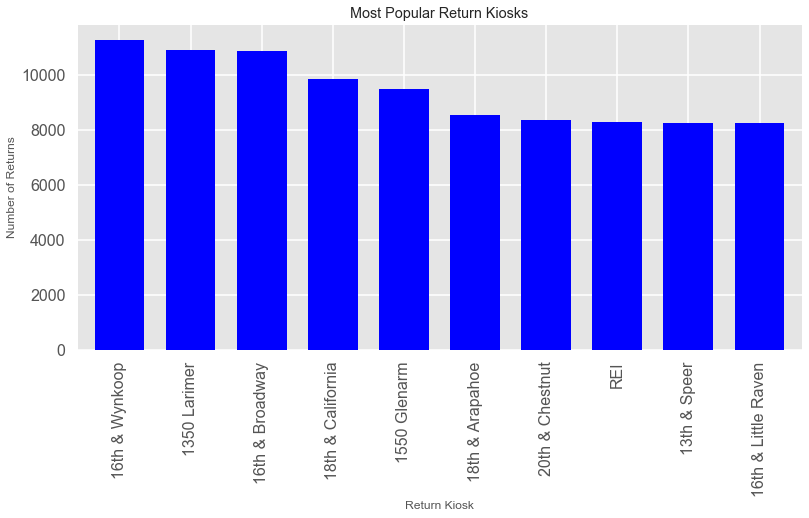

In [78]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Return Kiosks")
plt.xlabel('Return Kiosk')
plt.ylabel('Number of Returns')
plt.show()

### Map of Return Kiosk Popularity

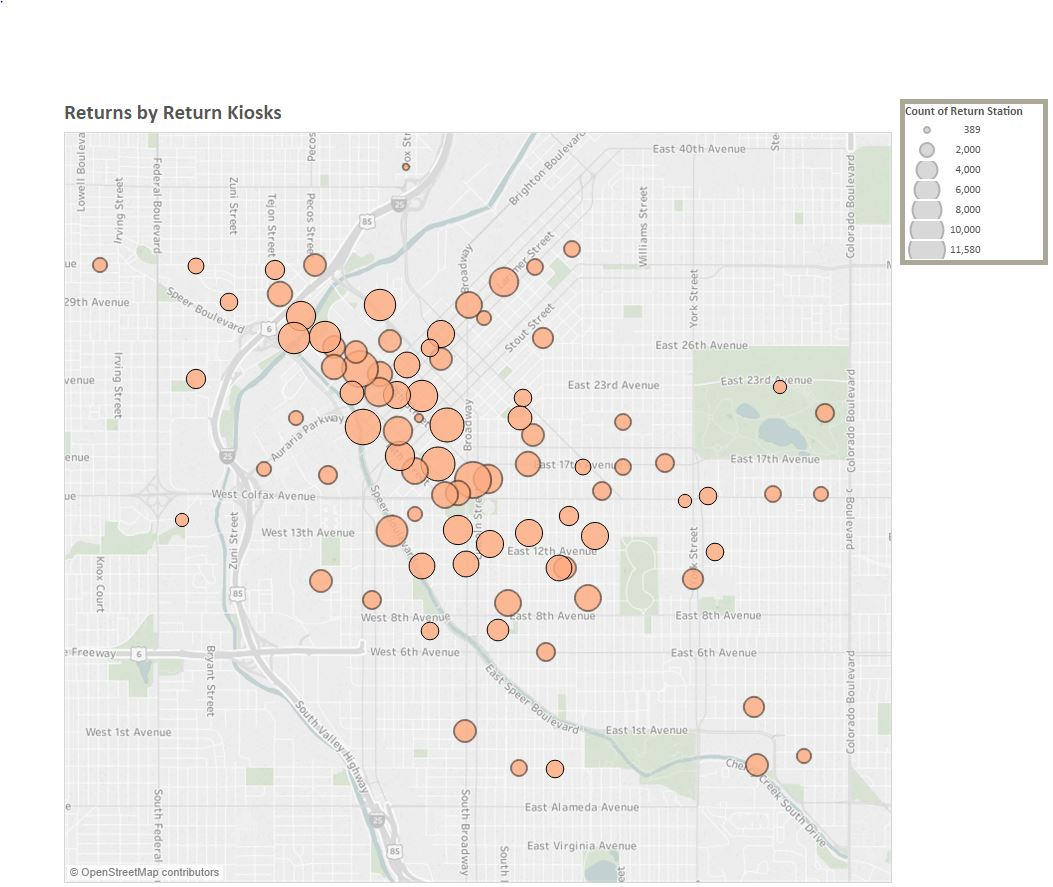

In [79]:
image = Image('data/Returns_By_Return_Kiosks.jpg')
image

### Least Popular Checkout Kiosks

In [80]:
# Least popular Checkout Kiosks
leastPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [81]:
leastPopular.tail(10)

Checkout_Kiosk
Pepsi Center                  1795
32nd & Julian                 1755
25th & Lawrence               1736
Colfax & Garfield             1725
4th & Walnut                  1663
Decatur Federal Light Rail    1508
Denver Zoo                    1490
Colfax & Gaylord              1421
17th & Curtis                  615
39th & Fox                     332
dtype: int64

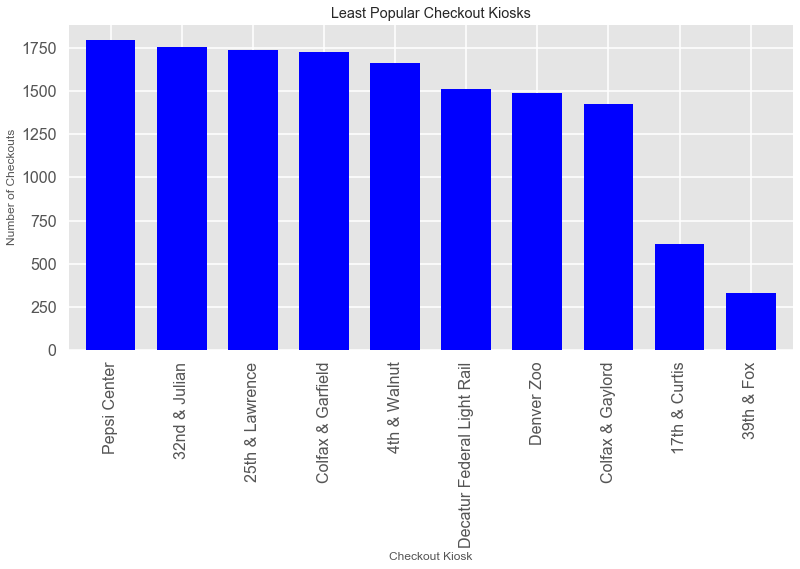

In [82]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Checkout Kiosks")
plt.xlabel('Checkout Kiosk')
plt.ylabel('Number of Checkouts')
plt.show()

### Least Popular Return Kiosks

In [83]:
# Least popular Return Kiosks
leastPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [84]:
leastPopular.tail(10)

Return_Kiosk
21st & Market                 1795
32nd & Julian                 1767
25th & Lawrence               1758
Colfax & Garfield             1743
4th & Walnut                  1686
Decatur Federal Light Rail    1537
Denver Zoo                    1468
Colfax & Gaylord              1433
17th & Curtis                  632
39th & Fox                     345
dtype: int64

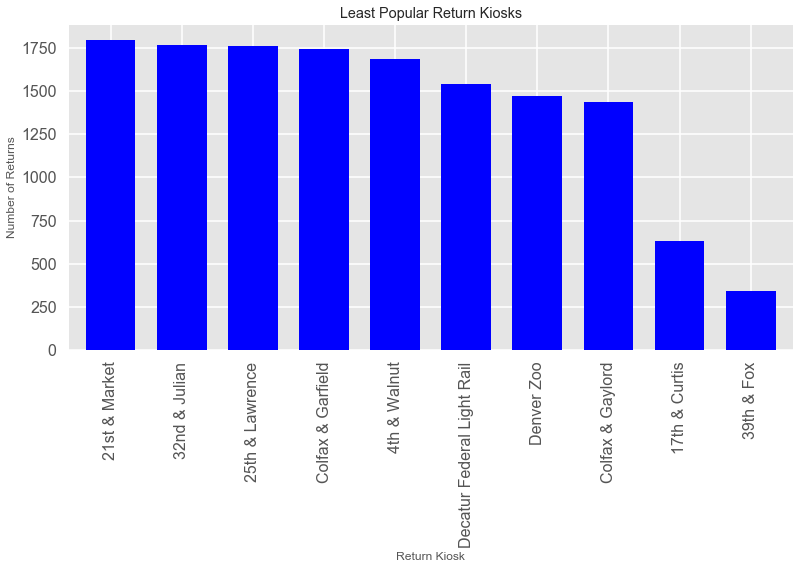

In [85]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Return Kiosks")
plt.xlabel('Return Kiosk')
plt.ylabel('Number of Returns')
plt.show()

### Checkouts Per Membership Type

In [86]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)

In [87]:
# there are 56250 rows with Membership = Not Applicable, a significant 14%
membership.head(10)

Membership_Type
24-hour Kiosk Only (Denver B-cycle)          85680
Annual Plus (Denver B-cycle)                 82202
Annual (Denver B-cycle)                      80093
Not Applicable                               56250
Monthly (Denver B-cycle)                     52811
Denver B-cycle Founder (Denver B-cycle)      17675
Single Ride (Denver B-cycle)                 16291
Republic Rider (Annual) (Boulder B-cycle)     5930
Flex Pass (Denver B-cycle)                    3507
Republic Rider (Boulder B-cycle)              1229
dtype: int64

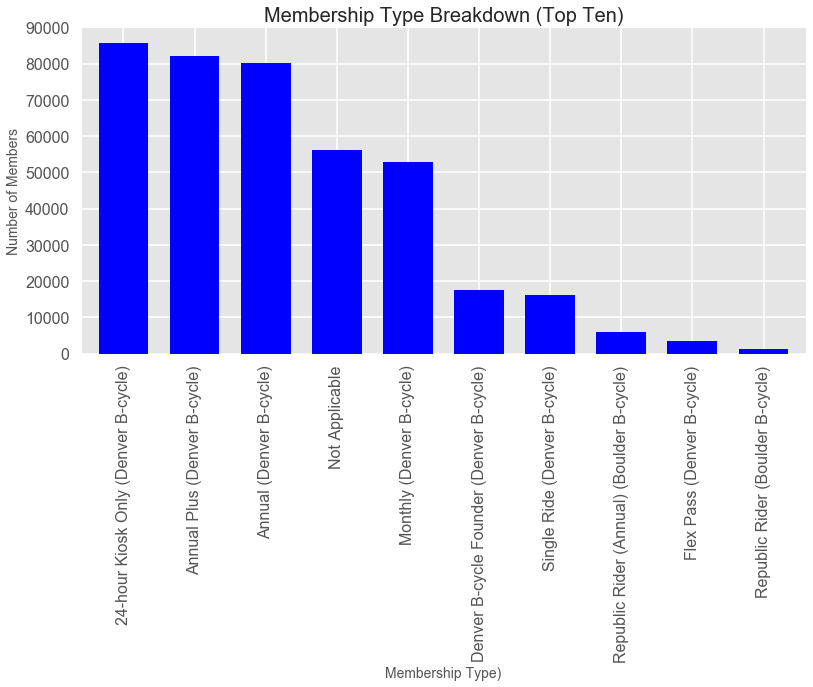

In [88]:
# plot the results
ax = dF.groupby('Membership_Type').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Membership Type Breakdown (Top Ten)', fontsize = 20)
plt.xlabel('Membership Type)', fontsize = 14)
plt.ylabel('Number of Members', fontsize = 14)
plt.show()

In [89]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23:21:00,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.260
1,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13:19:00,REI,2016-01-01,13:46:00,Broadway & Walnut,27,1.995
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13:19:00,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,1.542


In [90]:
dF.rename(columns = {'Checkout_Time' : 'Checkout_Hour'}, inplace = True)

### Convert Checkout Time to Checkout_Hour

In [91]:
dF['Checkout_Hour'] = dF['Checkout_Hour'].map(lambda x: x[:2]).astype(int)

In [92]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.260
1,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13,REI,2016-01-01,13:46:00,Broadway & Walnut,27,1.995
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,1.542


### Ridership by Calendar and Clock Variables

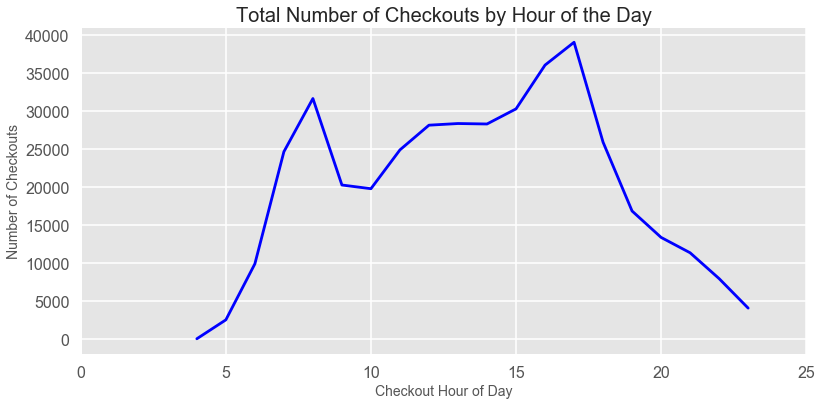

In [93]:
# plot the results
ax = dF.groupby('Checkout_Hour').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,25))
plt.title('Total Number of Checkouts by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [94]:
dH = dF.groupby(['Checkout_Hour']).mean()

In [95]:
dH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 4 to 23
Data columns (total 3 columns):
User_ID          20 non-null float64
Trip_Duration    20 non-null float64
Trip_Distance    20 non-null float64
dtypes: float64(3)
memory usage: 640.0 bytes


In [96]:
dH.drop(['User_ID', 'Trip_Duration'], axis=1, inplace=True)

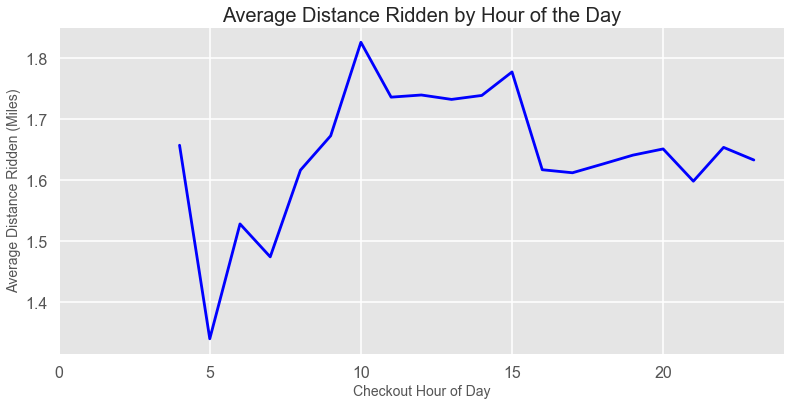

In [97]:
ax = dH.plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,24))
plt.title('Average Distance Ridden by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Average Distance Ridden (Miles)', fontsize = 14)
ax.legend().set_visible(False)
plt.show()

### Ridership by Hour and Weekday

#### Create Checkout_Weekday Column in Weather dataframe

In [98]:
# Create a new column called Checkout_WeekDay
dF['Checkout_WeekDay'] = pd.DatetimeIndex(dF['Checkout_Date']).weekday

In [99]:
dMon = dF.where(dF['Checkout_WeekDay'] == 0)
dTue = dF.where(dF['Checkout_WeekDay'] == 1)
dWed = dF.where(dF['Checkout_WeekDay'] == 2)
dThu = dF.where(dF['Checkout_WeekDay'] == 3)
dFri = dF.where(dF['Checkout_WeekDay'] == 4)
dSat = dF.where(dF['Checkout_WeekDay'] == 5)
dSun = dF.where(dF['Checkout_WeekDay'] == 6)

In [100]:
axMon = dMon.groupby('Checkout_Hour').size()
axTue = dTue.groupby('Checkout_Hour').size()
axWed = dWed.groupby('Checkout_Hour').size()
axThu = dThu.groupby('Checkout_Hour').size()
axFri = dFri.groupby('Checkout_Hour').size()
axSat = dSat.groupby('Checkout_Hour').size()
axSun = dSun.groupby('Checkout_Hour').size()

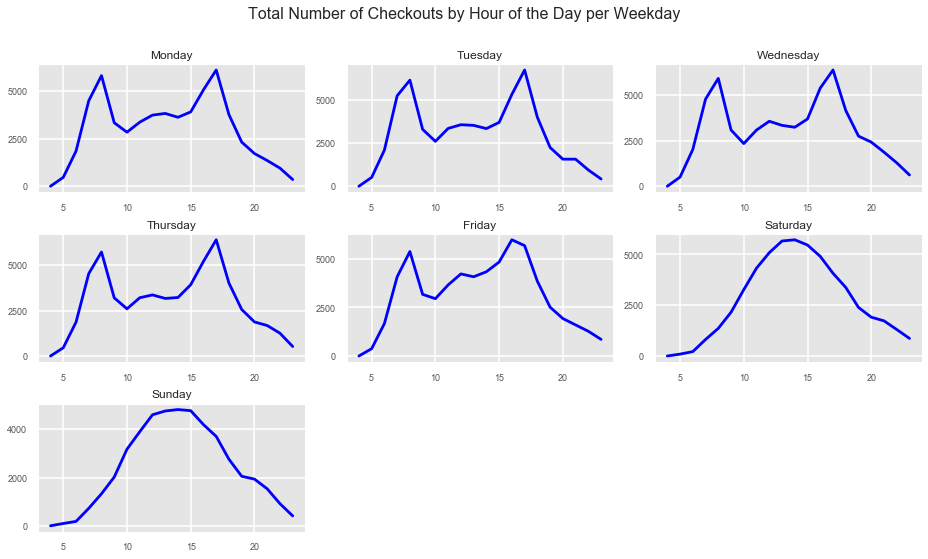

In [101]:
# plot the results
plt.figure()
plt.figure(figsize=(13,10))
plt.suptitle('Total Number of Checkouts by Hour of the Day per Weekday', fontsize=16)

#plt.xlabel('xlabel', fontsize=10)
#plt.ylabel('ylabel', fontsize=10)
plt.subplot(4,3,1)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Monday', fontsize=12)
plt.plot(axMon,'b-')

plt.subplot(4,3,2)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Tuesday', fontsize=12)
plt.plot(axTue,'b-')

plt.subplot(4,3,3)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Wednesday', fontsize=12)
plt.plot(axWed,'b-')

plt.subplot(4,3,4)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Thursday', fontsize=12)
plt.plot(axThu,'b-')

plt.subplot(4,3,5)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)  
plt.title('Friday', fontsize=12)
plt.plot(axFri,'b-')

plt.subplot(4,3,6)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Saturday', fontsize=12)
plt.plot(axSat,'b-')

plt.subplot(4,3,7)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Sunday', fontsize=12)
plt.plot(axSun,'b-')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig = plt.gca()

### Ridership by Month

#### Create Checkout_Month column in Trips dataframe

In [102]:
# Create a new column called Checkout_Month
dF['Checkout_Month'] = pd.DatetimeIndex(dF['Checkout_Date']).month

In [103]:
dM = dF.groupby(['Checkout_Month'])

In [104]:
dM.size()

Checkout_Month
1     17649
2     22040
3     27243
4     32421
5     41045
6     50619
7     41871
8     43382
9     45490
10    41228
11    27258
12    12719
dtype: int64

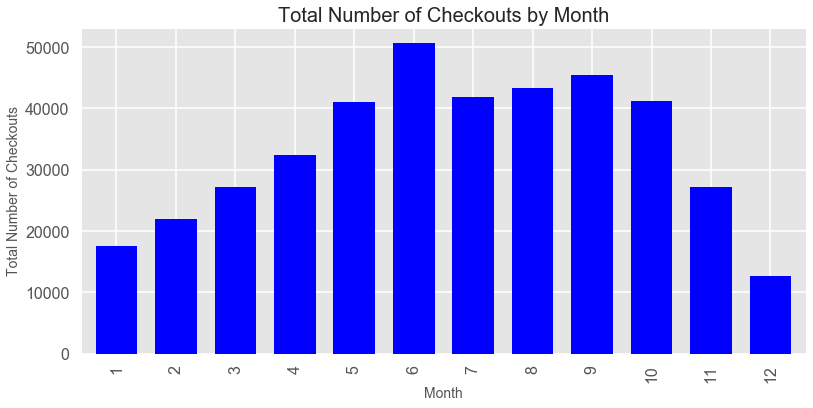

In [105]:
# plot the results
ax = dF.groupby('Checkout_Month').size().plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Total Number of Checkouts by Month', fontsize = 20)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Total Number of Checkouts', fontsize = 14)
plt.show()

## Merging with Weather

### Merge Daily Weather Data with Trips DataFrame

In [106]:
dW = pd.read_csv("data/Denver_2016_Daily_Weather_Forecast.csv")

In [107]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 9 columns):
Date                      366 non-null object
cloudCover                366 non-null float64
apparentTemperatureMax    366 non-null float64
apparentTemperatureMin    366 non-null float64
temperatureMax            366 non-null float64
temperatureMin            366 non-null float64
windSpeed                 366 non-null float64
humidity                  366 non-null float64
visibility                366 non-null float64
dtypes: float64(8), object(1)
memory usage: 25.8+ KB


In [108]:
dW.head(3)

,Date,cloudCover,apparentTemperatureMax,apparentTemperatureMin,temperatureMax,temperatureMin,windSpeed,humidity,visibility
0,2016-01-01,0.030,32.320,-5.680,32.320,4.440,3.740,0.560,9.840
1,2016-01-02,0.100,39.010,5.170,39.010,14.000,3.310,0.440,10.000
2,2016-01-03,0.140,39.550,9.330,41.190,15.580,2.290,0.490,9.990


In [109]:
dW.isnull().values.any()

False

In [110]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [111]:
dW.sort_values(['Date'], inplace=True)

In [112]:
#dW.drop(['cloudCover', 'windSpeed', 'humidity'], axis = 1, inplace=True)

In [113]:
dF = pd.merge(dF, dW, how='left', left_on=['Checkout_Date'], right_on=['Date'])

In [114]:
dF.shape

(402965, 23)

In [115]:
dF.isnull().values.any()

False

In [116]:
dF.drop(['Date'], axis = 1, inplace = True)

### Ridership by Day

Plot above shows temperature affects ridership. Daily temperatures in the 70s to 80s result in the highest ridership while temperatures 35F and below result in the lowest ridership. Also, ridership is high on weekends (Sunday, labeled as 6 and Saturday, labeled as 5) and during the months between May and June. Conversely, the winter months (December to February) have the lowest ridership unless the temperature is favorable on those days, which is typical of Colorado.

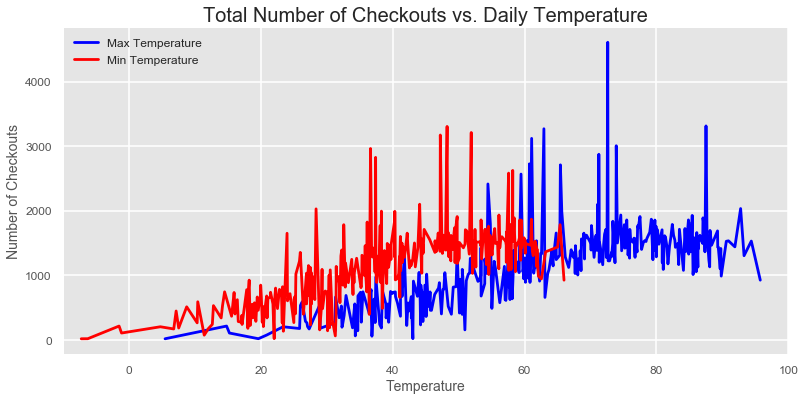

In [117]:
ax = dF.groupby('temperatureMax').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Max Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('temperatureMin').size().plot(kind='line', figsize=(13,6), 
                color='red', label='Min Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Temperature', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

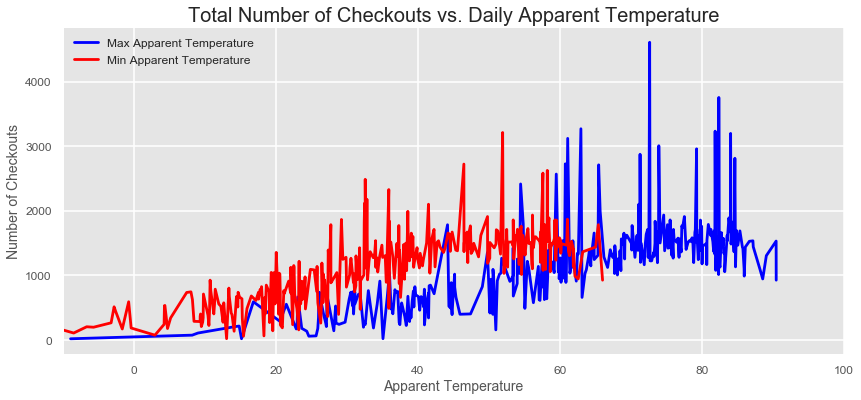

In [118]:
ax = dF.groupby('apparentTemperatureMax').size().plot(kind='line', figsize=(14,6), 
                color='blue', label='Max Apparent Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('apparentTemperatureMin').size().plot(kind='line', figsize=(14,6), 
                color='red', label='Min Apparent Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Apparent Temperature', fontsize = 20)
plt.xlabel('Apparent Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

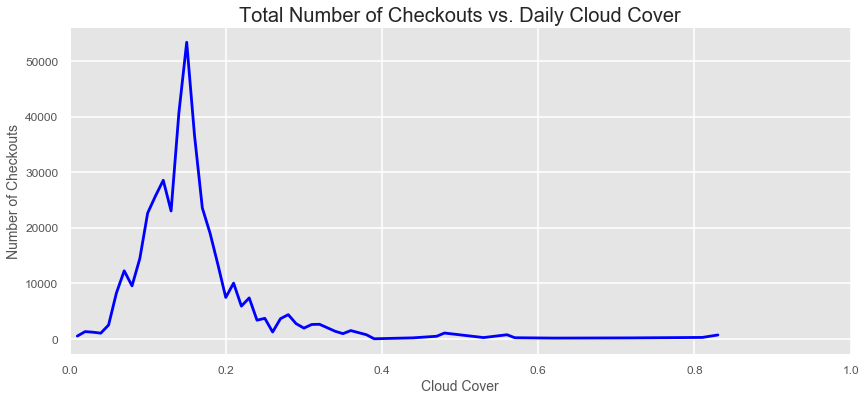

In [119]:
ax = dF.groupby('cloudCover').size().plot(kind='line', figsize=(14,6), 
                color='blue', fontsize=12, xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

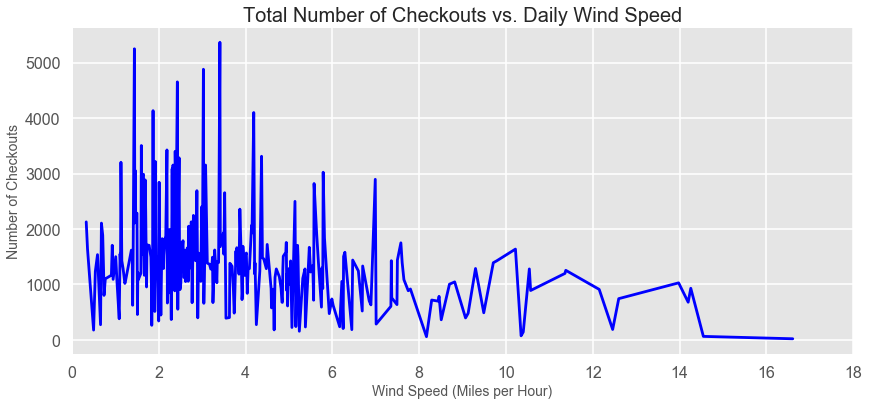

In [120]:
ax = dF.groupby('windSpeed').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,18))
plt.title('Total Number of Checkouts vs. Daily Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

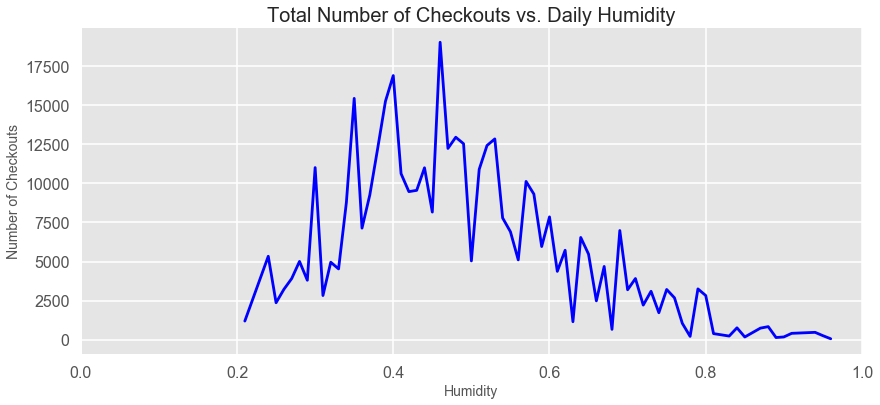

In [121]:
ax = dF.groupby('humidity').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

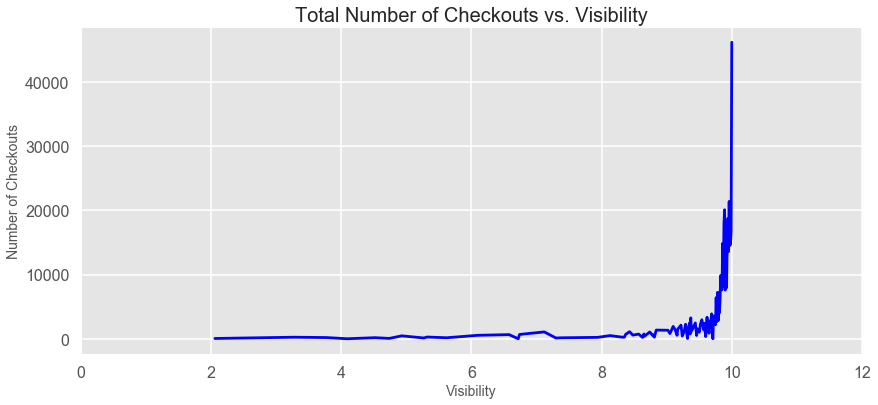

In [122]:
ax = dF.groupby('visibility').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,12))
plt.title('Total Number of Checkouts vs. Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [123]:
dHRD = dF.groupby(['Checkout_WeekDay', 'Checkout_Date', 'temperatureMax', 'temperatureMin'])['Checkout_WeekDay']

In [124]:
dHRD.size().sort_values(ascending=False).head(10)

Checkout_WeekDay  Checkout_Date  temperatureMax  temperatureMin
6                 2016-05-29     71.090          44.100            2100
5                 2016-05-28     65.650          40.330            1990
4                 2016-06-03     74.600          56.120            1933
2                 2016-06-15     85.430          51.980            1927
5                 2016-05-21     77.510          49.790            1909
0                 2016-06-27     87.060          58.440            1889
5                 2016-06-25     79.230          61.040            1868
                  2016-06-04     75.500          53.410            1857
3                 2016-06-23     84.860          59.280            1857
4                 2016-09-02     79.770          59.500            1855
dtype: int64

In [125]:
dHRD.size().sort_values(ascending=False).tail(10)

Checkout_WeekDay  Checkout_Date  temperatureMax  temperatureMin
5                 2016-12-24     50.960          28.940            154
6                 2016-04-17     34.710          30.140            140
                  2016-01-31     31.260          23.430            133
2                 2016-12-07     15.250          -1.110            105
1                 2016-02-02     20.870          11.430             72
5                 2016-04-16     34.340          31.310             61
6                 2016-12-25     36.860          25.290             56
2                 2016-03-23     43.070          22.040             18
6                 2016-12-18     19.640          -6.220             17
5                 2016-12-17     5.490           -7.220             16
dtype: int64

In [126]:
dF.drop(['apparentTemperatureMax', 'apparentTemperatureMin', 'temperatureMax', 'temperatureMin',
         'cloudCover', 'humidity', 'windSpeed', 'visibility'], axis = 1, inplace = True)

### Merge Hourly Weather with Trips DataFrame

In [127]:
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [128]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
Date                   8784 non-null object
Hour                   8784 non-null int64
apparentTemperature    8784 non-null float64
cloudCover             8782 non-null float64
humidity               8784 non-null float64
temperature            8784 non-null float64
visibility             8784 non-null float64
windSpeed              8784 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 549.1+ KB


In [129]:
dW.head(3)

,Date,Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed
0,2016-01-01,0,-0.350,0.040,0.800,8.120,9.010,4.560
1,2016-01-01,1,6.770,0.040,0.800,6.770,9.330,2.110
2,2016-01-01,2,6.230,0.000,0.800,6.230,9.480,2.360


In [130]:
dW.describe()

,Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed
count,8784.000,8784.000,8782.000,8784.000,8784.000,8784.000,8784.000
mean,11.500,47.631,0.174,0.512,49.892,9.522,5.790
std,6.923,20.481,0.173,0.214,18.511,1.349,3.619
min,0.000,-17.450,0.000,0.090,-7.220,0.200,0.070
25%,5.750,31.750,0.090,0.330,36.110,9.670,3.450
50%,11.500,49.965,0.150,0.490,50.000,10.000,4.990
75%,17.250,63.402,0.200,0.680,63.402,10.000,7.150
max,24.000,90.440,1.000,0.970,95.750,10.000,30.140


In [131]:
dW.isnull().values.any()

True

In [132]:
nan_rows = dW[dW.isnull().T.any().T]

In [133]:
nan_rows

,Date,Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed
744,2016-02-01,0,16.360,nan,0.880,24.260,6.560,6.750
745,2016-02-01,1,15.680,nan,0.880,24.300,6.170,7.700


In [134]:
dW = dW.drop(dW.index[nan_rows.index])

In [135]:
dW.isnull().values.any()

False

#### Convert Date column in Weather dataframe

In [136]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [137]:
dW.sort_values(['Date', 'Hour'], inplace=True)

In [138]:
dW.head(3)

,Date,Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed
0,2016-01-01,0,-0.350,0.040,0.800,8.120,9.010,4.560
1,2016-01-01,1,6.770,0.040,0.800,6.770,9.330,2.110
2,2016-01-01,2,6.230,0.000,0.800,6.230,9.480,2.360


In [139]:
dW.describe()

,Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed
count,8782.000,8782.000,8782.000,8782.000,8782.000,8782.000,8782.000
mean,11.503,47.638,0.174,0.512,49.898,9.522,5.790
std,6.922,20.478,0.173,0.214,18.509,1.349,3.619
min,0.000,-17.450,0.000,0.090,-7.220,0.200,0.070
25%,6.000,31.765,0.090,0.330,36.112,9.670,3.450
50%,12.000,50.005,0.150,0.490,50.005,10.000,4.990
75%,17.750,63.407,0.200,0.680,63.407,10.000,7.150
max,24.000,90.440,1.000,0.970,95.750,10.000,30.140


In [140]:
dF = pd.merge(dF, dW, how='left', left_on=['Checkout_Date', 'Checkout_Hour'], right_on=['Date', 'Hour'])

In [141]:
dF.shape

(402965, 22)

In [142]:
dF.isnull().values.any()

True

In [143]:
nan_rows = dF[dF.isnull().T.any().T]

In [144]:
nan_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 53484 to 53486
Data columns (total 22 columns):
User_Program           3 non-null object
User_ID                3 non-null int64
Membership_Type        3 non-null object
Bike_Number            3 non-null object
Checkout_Date          3 non-null datetime64[ns]
Checkout_Hour          3 non-null int32
Checkout_Kiosk         3 non-null object
Return_Date            3 non-null datetime64[ns]
Return_Time            3 non-null object
Return_Kiosk           3 non-null object
Trip_Duration          3 non-null int64
Trip_Distance          3 non-null float64
Checkout_WeekDay       3 non-null int32
Checkout_Month         3 non-null int32
Date                   0 non-null datetime64[ns]
Hour                   0 non-null float64
apparentTemperature    0 non-null float64
cloudCover             0 non-null float64
humidity               0 non-null float64
temperature            0 non-null float64
visibility             0 non-null float64
wind

In [145]:
dF = dF.drop(dF.index[nan_rows.index])

In [146]:
dF.isnull().values.any()

False

In [147]:
dF.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month,Date,Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.260,4,1,2016-01-01,23.000,9.710,0.000,0.530,14.990,10.000,3.200
1,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),890,2016-01-01,13,REI,2016-01-01,13:46:00,Broadway & Walnut,27,1.995,4,1,2016-01-01,13.000,27.440,0.110,0.310,31.740,9.830,4.310
2,Denver B-cycle,770572,Annual Plus (Denver B-cycle),753,2016-01-01,13,10th & Osage,2016-01-01,13:46:00,10th & Osage,27,1.542,4,1,2016-01-01,13.000,27.440,0.110,0.310,31.740,9.830,4.310
3,Denver B-cycle,1051979,24-hour Kiosk Only (Denver B-cycle),164,2016-01-01,13,14th & Stout,2016-01-01,13:43:00,Denver Public Library,24,0.820,4,1,2016-01-01,13.000,27.440,0.110,0.310,31.740,9.830,4.310
4,Denver B-cycle,1051983,24-hour Kiosk Only (Denver B-cycle),4,2016-01-01,13,REI,2016-01-01,13:46:00,Broadway & Walnut,28,1.995,4,1,2016-01-01,13.000,27.440,0.110,0.310,31.740,9.830,4.310


In [148]:
dF.drop(['Date'], axis = 1, inplace = True)
dF.drop(['Hour'], axis = 1, inplace = True)

### Checkouts vs. Hourly Temperature

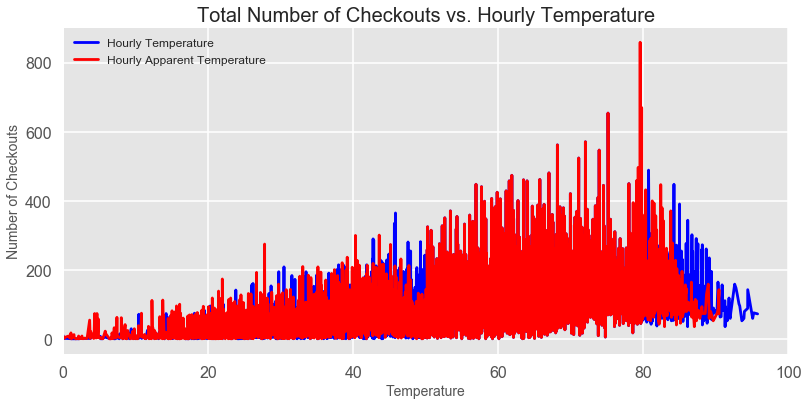

In [149]:
ax = dF.groupby('temperature').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Hourly Temperature', xlim=(0,100))
ax = dF.groupby('apparentTemperature').size().plot(kind='line', figsize=(13,6), 
                color='red', label='Hourly Apparent Temperature', xlim=(0,100))
plt.title('Total Number of Checkouts vs. Hourly Temperature', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

### Checkouts vs. Hourly Humidity

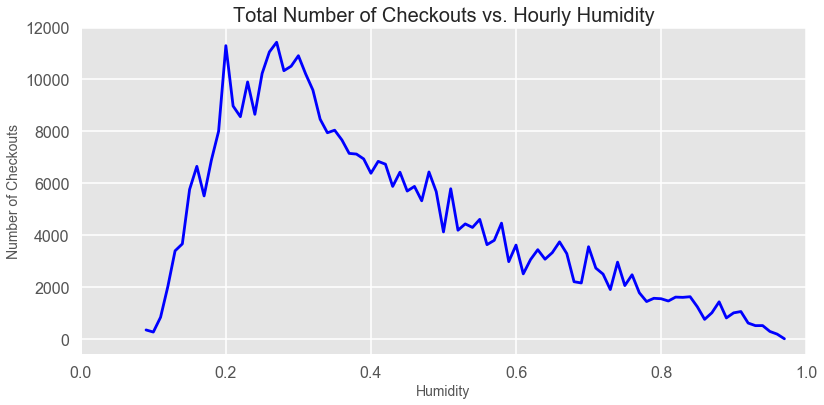

In [150]:
ax = dF.groupby('humidity').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Hourly Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Cloud Cover

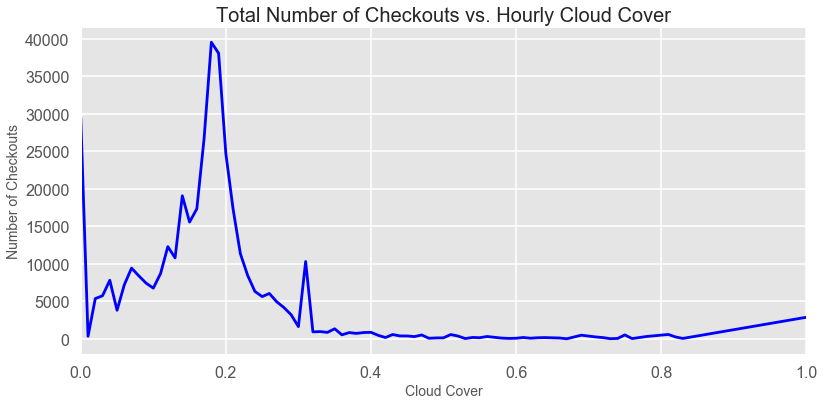

In [151]:
ax = dF.groupby('cloudCover').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Hourly Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Wind Speed

Wind speed significantly impacts ridership. Speeds between 0 and 5 miles per hour are very favorable to renting bikes. Rideship radipdly diminshes at 10 or higher miles per hour.

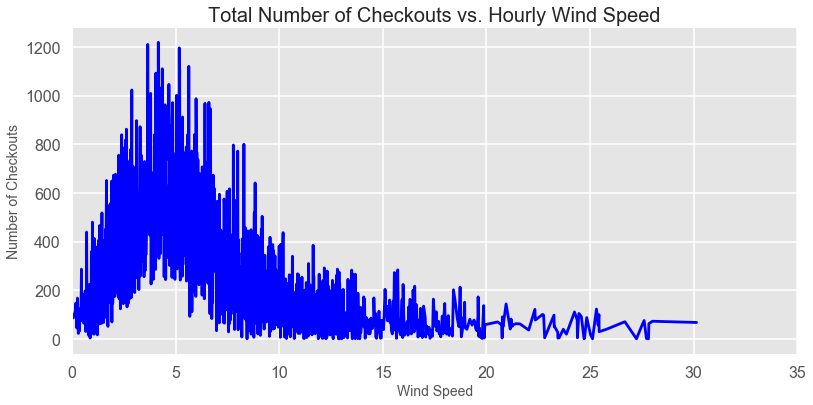

In [152]:
ax = dF.groupby('windSpeed').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,35))
plt.title('Total Number of Checkouts vs. Hourly Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Visibility

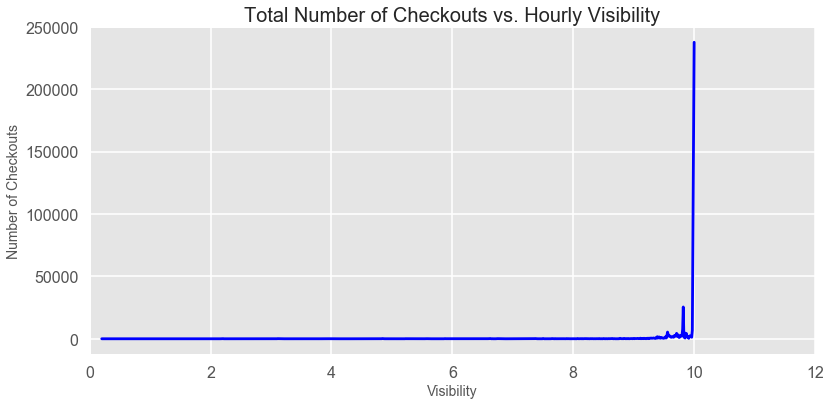

In [153]:
ax = dF.groupby('visibility').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,12))
plt.title('Total Number of Checkouts vs. Hourly Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [154]:
dF.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [155]:
# save csv file in preparation for use in the Machine Learning phase
dF.to_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", index=False, compression="gzip")